In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, eig
import mat73

In [28]:
data = mat73.loadmat('/mnt/c/users/ankku/downloads/assignmentShapeAnalysis/data/hands2D.mat')

shapes = data['shapes']  
num_samples = shapes.shape[2]
shapes_matrix = data['shapes'] 

In [29]:
shapes_raw = []

for i in range(shapes_matrix.shape[2]):
    x = shapes_matrix[0, :, i]
    y = shapes_matrix[1, :, i]
    shape = np.stack([x, y], axis=1)  # shape = (num_points, 2)
    shapes_raw.append(shape)

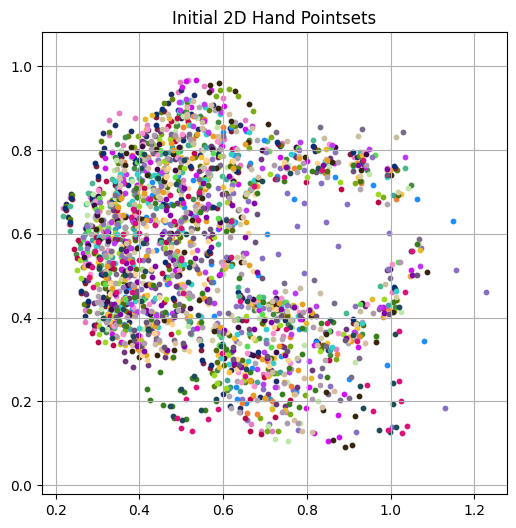

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_initial_shapes(shapes):
    plt.figure(figsize=(6, 6))
    for shape in shapes:
        color = np.random.rand(3,)
        plt.scatter(shape[:, 0], shape[:, 1], color=color, s=10)
    plt.title("Initial 2D Hand Pointsets")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_initial_shapes(shapes_raw)

In [31]:
def center_pointset(pts):
    return pts - np.mean(pts, axis=0)

In [32]:
def normalize_pointset(pts):
    norm = np.linalg.norm(pts, 'fro')
    return pts / norm if norm != 0 else pts

In [33]:
def to_preshape(pts):
    return normalize_pointset(center_pointset(pts))

In [34]:
import numpy as np

def align_by_rotation(X, Y):
    A = Y.T @ X
    
    U, _, Vt = np.linalg.svd(A)
    R = U @ Vt
    
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt

    Y_aligned = Y @ R
    return Y_aligned, R

In [35]:
import numpy as np

def align_by_similarity(X, Y):

    mu_X = np.mean(X, axis=0)
    mu_Y = np.mean(Y, axis=0)
    
    Xc = X - mu_X
    Yc = Y - mu_Y

    norm_X = np.linalg.norm(Xc)
    norm_Y = np.linalg.norm(Yc)
    s = norm_X / norm_Y if norm_Y != 0 else 1.0

    Ycs = Yc * s

    A = Ycs.T @ Xc
    U, _, Vt = np.linalg.svd(A)
    R = U @ Vt
    
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt

    Y_aligned = (Yc @ R) * s + mu_X
    
    t = mu_X - s * (mu_Y @ R)

    return Y_aligned, s, R, t


In [36]:
def compute_shape_mean_code11(shapes, max_iter=20, tol=1e-6):
    shapes_preshape = [to_preshape(shape) for shape in shapes]
    mean_shape = shapes_preshape[0]
    aligned_shapes = [None] * len(shapes_preshape)
    for _ in range(max_iter):
        for i, shape in enumerate(shapes_preshape):
            aligned, _ = align_by_rotation(mean_shape, shape)
            aligned_shapes[i] = aligned
        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = normalize_pointset(new_mean)
        if np.linalg.norm(mean_shape - new_mean, 'fro') < tol:
            break
        mean_shape = new_mean
    return mean_shape, aligned_shapes

In [37]:
def compute_shape_mean_code22(shapes, max_iter=20, tol=1e-6):
    mean_shape = shapes[0]
    aligned_shapes = [None] * len(shapes)
    for _ in range(max_iter):
        for i, shape in enumerate(shapes):
            aligned, _, _, _ = align_by_similarity(mean_shape, shape)
            aligned_shapes[i] = aligned
        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = center_pointset(new_mean)
        new_mean = normalize_pointset(new_mean)
        if np.linalg.norm(mean_shape - new_mean, 'fro') < tol:
            break
        mean_shape = new_mean
    return mean_shape, aligned_shapes

In [38]:
mean11, aligned11 = compute_shape_mean_code11(shapes_raw)

mean22, aligned22 = compute_shape_mean_code22(shapes_raw)

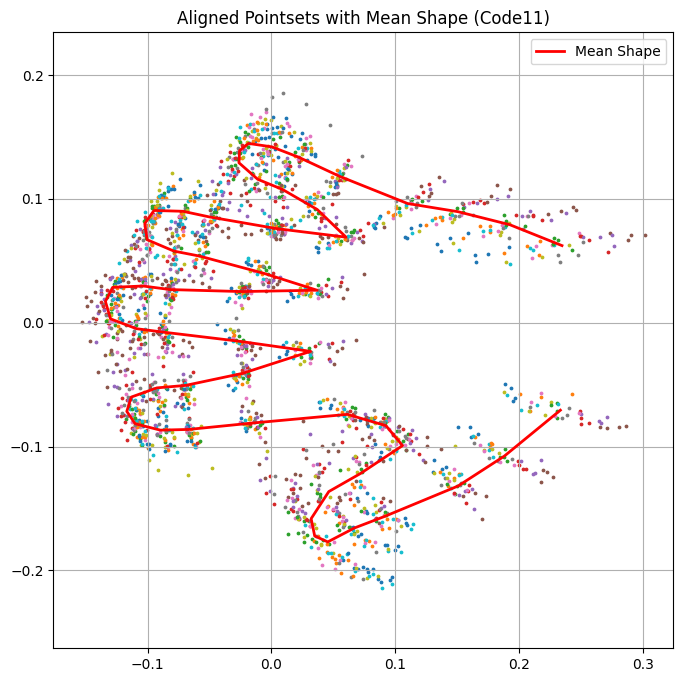

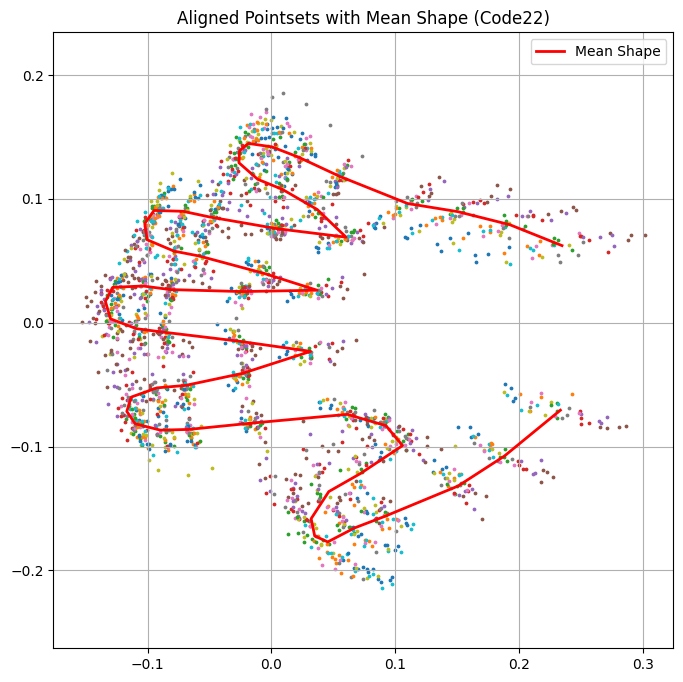

In [39]:
def plot_mean_with_aligned_points(mean_shape, aligned_shapes, title):

    plt.figure(figsize=(8, 8))

    for shape in aligned_shapes:
        plt.scatter(shape[:, 0], shape[:, 1], s=3, alpha=1)

    plt.plot(mean_shape[:, 0], mean_shape[:, 1], color='red', linewidth=2, label='Mean Shape')

    plt.title(title)
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_mean_with_aligned_points(mean11, aligned11, "Aligned Pointsets with Mean Shape (Code11)")

plot_mean_with_aligned_points(mean22, aligned22, "Aligned Pointsets with Mean Shape (Code22)")

In [40]:
def compute_shape_pca(aligned_shapes):

    num_shapes = len(aligned_shapes)
    num_points = aligned_shapes[0].shape[0]

    shape_vectors = np.array([shape.flatten() for shape in aligned_shapes])  # shape: (num_shapes, 2*num_points)

    mean_vec = np.mean(shape_vectors, axis=0)
    centered_data = shape_vectors - mean_vec

    cov_matrix = np.cov(centered_data.T)

    eigvals, _ = np.linalg.eigh(cov_matrix)
    eigvals_sorted = np.sort(eigvals)[::-1] 

    return eigvals_sorted


In [41]:
def plot_top_3_variances(eigvals, title):
    top3 = eigvals[:3]
    plt.figure()
    plt.bar(range(1, 4), top3, color='skyblue')
    plt.xlabel("Principal Mode")
    plt.ylabel("Variance (Eigenvalue)")
    plt.title(title)
    plt.grid(True)
    plt.show()


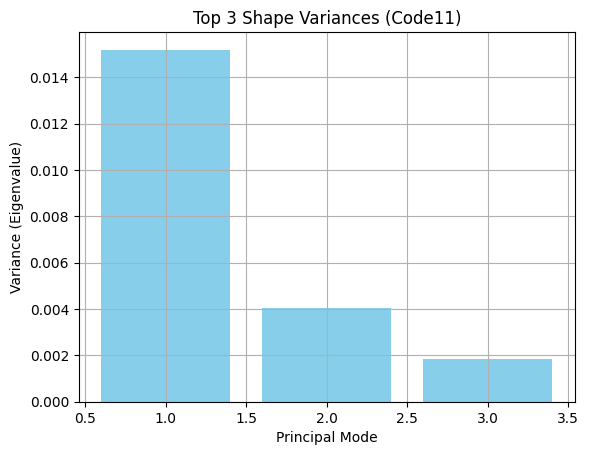

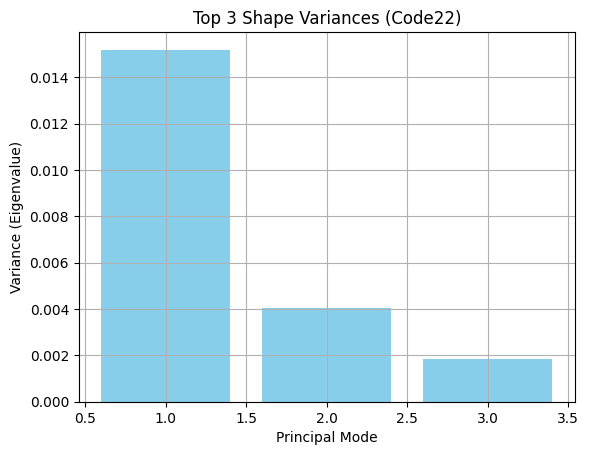

In [42]:
eigvals_11 = compute_shape_pca(aligned11)
eigvals_22 = compute_shape_pca(aligned22)

plot_top_3_variances(eigvals_11, "Top 3 Shape Variances (Code11)")
plot_top_3_variances(eigvals_22, "Top 3 Shape Variances (Code22)")

In [43]:
def compute_pca_with_modes(aligned_shapes):
    num_shapes = len(aligned_shapes)
    num_points = aligned_shapes[0].shape[0]

    shape_vectors = np.array([shape.flatten() for shape in aligned_shapes])  # (num_shapes, 2*num_points)

    mean_vec = np.mean(shape_vectors, axis=0)
    centered = shape_vectors - mean_vec

    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)

    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    return mean_vec, eigvals, eigvecs

In [70]:
def reconstruct_variation(mean_vec, eigvals, eigvecs, mode_index, std_multiplier=2):
    deviation = std_multiplier * np.sqrt(eigvals[mode_index])
    shape_plus = mean_vec + deviation * eigvecs[:, mode_index]
    shape_minus = mean_vec - deviation * eigvecs[:, mode_index]
    return shape_minus, shape_plus

In [103]:
def plot_variations(mean_vec, eigvals, eigvecs, aligned_shapes, title, k=2):
    num_points = len(mean_vec) // 2
    mean_shape = mean_vec.reshape((num_points,2))
    plt.figure(figsize=(12,8))
    
    plt.subplot(2,2,1)
    for pts in aligned_shapes:
        plt.plot(pts[:,0], pts[:,1], 'o', alpha=0.4)
    plt.plot(mean_shape[:,0], mean_shape[:,1], 'r-', linewidth=2, label='Mean')
    plt.gca().invert_yaxis()
    plt.title(title + "\nAligned Shapes & Mean")
    plt.legend()
    plt.axis('equal')
    
    for i in range(3):
        minus, plus = reconstruct_variation(mean_vec, eigvals, eigvecs, i, std_multiplier=k)
        shape_minus = minus.reshape((num_points,2))
        shape_plus = plus.reshape((num_points,2))
        plt.subplot(2,3,i+4)
        plt.plot(mean_shape[:,0], mean_shape[:,1], 'r-', label='Mean')
        plt.plot(shape_minus[:,0], shape_minus[:,1], 'b--', label=f'-{k} SD')
        plt.plot(shape_plus[:,0], shape_plus[:,1], 'g--', label=f'+{k} SD')
        plt.gca().invert_yaxis()
        plt.title(f"Mode {i+1} Variation")
        plt.legend()
        plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [104]:
mean_vec_11, eigvals_11_modes, eigvecs_11 = compute_pca_with_modes(aligned11)
mean_vec_22, eigvals_22_modes, eigvecs_22 = compute_pca_with_modes(aligned22)

/tmp/ipykernel_83429/929694487.py:27: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


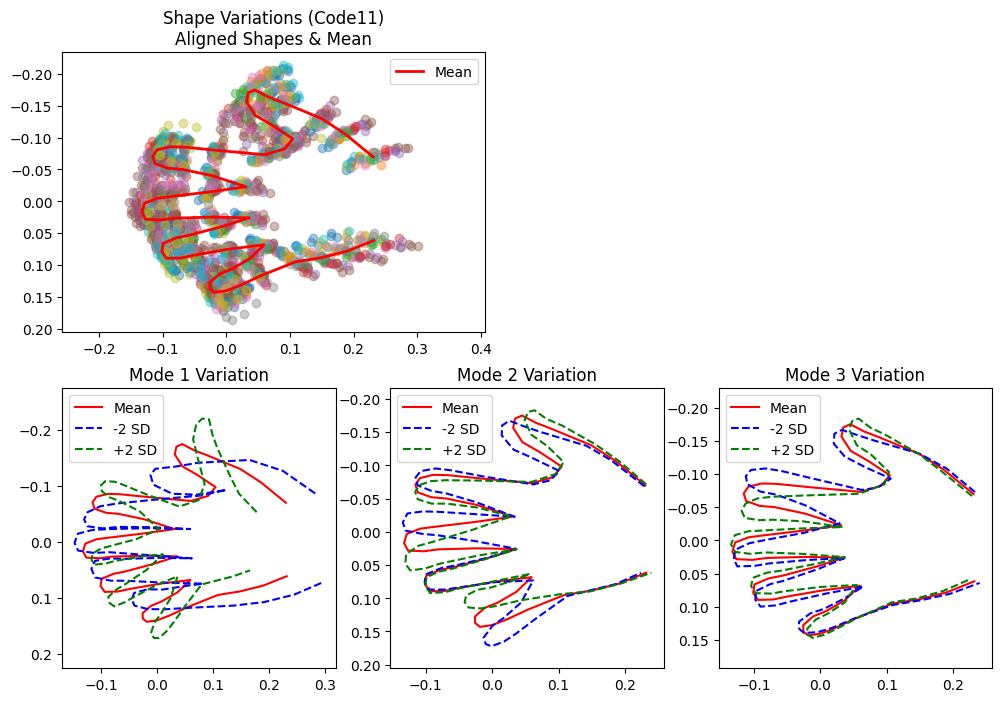

In [105]:
plot_variations(mean_vec_11, eigvals_11, eigvecs_11, aligned11,
                "Shape Variations (Code11)", k=2)

/tmp/ipykernel_83429/929694487.py:27: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


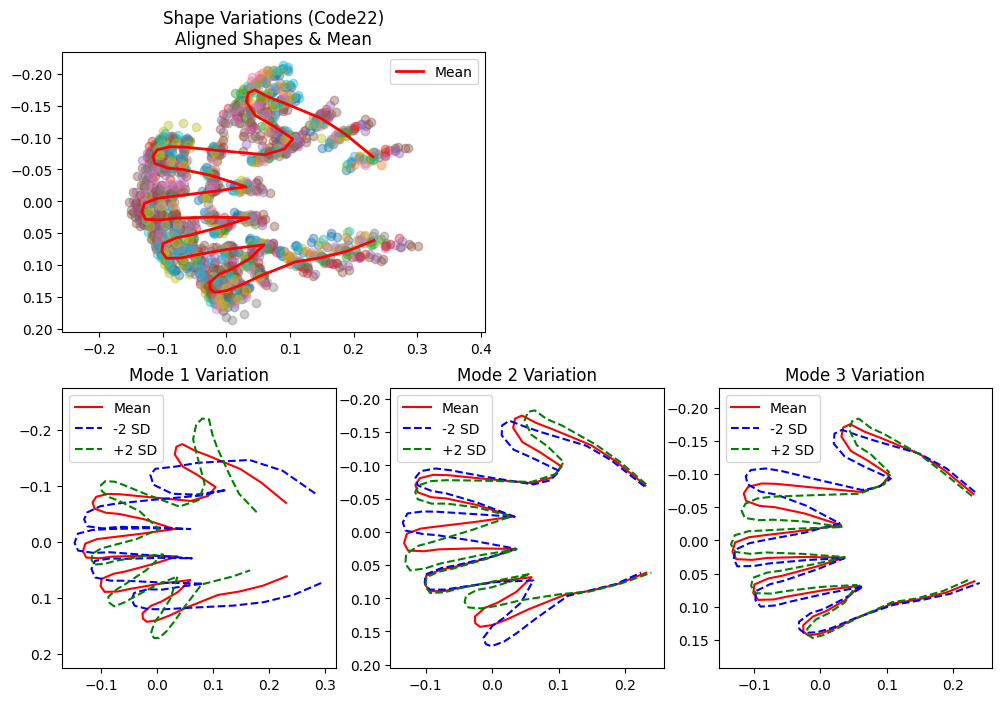

In [106]:
plot_variations(mean_vec_22, eigvals_22, eigvecs_22, aligned22,
                "Shape Variations (Code22)", k=2)